In [40]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
import evaluate
from datasets import load_dataset
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [3]:
dataset = load_dataset('csv', data_files='dataset/class.csv', split='train',)

Using custom data configuration default-c93cb783beac3038
Found cached dataset csv (C:/Users/Authority/.cache/huggingface/datasets/csv/default-c93cb783beac3038/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


In [4]:
# casting the label column to a ClassLabel
dataset = dataset.class_encode_column('label')

Loading cached processed dataset at C:\Users\Authority\.cache\huggingface\datasets\csv\default-c93cb783beac3038\0.0.0\6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-7d0d9b27e0247da5.arrow


In [5]:
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True)

In [6]:
tokenized_dataset = dataset.map(tokenize_function, batched=True)

Loading cached processed dataset at C:\Users\Authority\.cache\huggingface\datasets\csv\default-c93cb783beac3038\0.0.0\6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-cc691ec4b93b5afb.arrow


In [7]:
tokenized_train_dataset, tokenized_validation_dataset = tokenized_dataset.train_test_split(test_size=0.3, stratify_by_column='label').values()

In [8]:
tokenized_train_dataset.data

MemoryMappedTable
text: string
label: int64
input_ids: list<item: int32>
  child 0, item: int32
token_type_ids: list<item: int8>
  child 0, item: int8
attention_mask: list<item: int8>
  child 0, item: int8
----
text: [["metti i linkin park","metti la canzone dei linkin park","metti la sinfonia numero 5 di beeethoven","riproduci la sinfonia numero 5 di beeethoven","riproduci naturalmente",...,"sei un finocchio pezzo di merda","metti sei un finocchio","metti sporcizia","sporcizia","riproduci sporcizia"]]
label: [[4,4,4,4,2,...,1,1,6,6,6]]
input_ids: [[[101,2777,3775,1045,4957,2378,2380,102],[101,2777,3775,2474,2064,...,14866,4957,2378,2380,102],...,[101,11867,2953,6895,12871,102],[101,10973,14127,14194,2072,11867,2953,6895,12871,102]]]
token_type_ids: [[[0,0,0,0,0,0,0,0],[0,0,0,0,0,...,0,0,0,0,0],...,[0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0]]]
attention_mask: [[[1,1,1,1,1,1,1,1],[1,1,1,1,1,...,1,1,1,1,1],...,[1,1,1,1,1,1],[1,1,1,1,1,1,1,1,1,1]]]

In [9]:
# create a metric based on accuracy
metric = evaluate.load('accuracy')

In [10]:
# define a function that will compute the accuracy of the model
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [11]:
# instantiate the model
num_classes = tokenized_train_dataset.features['label'].num_classes
id2label = {i: label for i, label in enumerate(tokenized_train_dataset.features['label']._int2str)}
label2id = tokenized_train_dataset.features['label']._str2int
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_classes, id2label=id2label, label2id=label2id)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [12]:
# define the training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=30,              # total number of training epochs
    #per_device_train_batch_size=16,  # batch size per device during training
    #per_device_eval_batch_size=64,   # batch size for evaluation
    #warmup_steps=500,                # number of warmup steps for learning rate scheduler
    #weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy='epoch',
    learning_rate=2e-5,
)

In [13]:
# instantiate the Trainer
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=tokenized_train_dataset,         # training dataset
    eval_dataset=tokenized_validation_dataset,               # evaluation dataset
    compute_metrics=compute_metrics,         # the callback that computes metrics of interest
    tokenizer=tokenizer,
)

In [14]:
# train the model
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
C:\Users\Authority\Desktop\AudioSpeechModel\venv\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 18
  Num Epochs = 30
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 90
  Number of trainable parameters = 109487623
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is fa

Epoch,Training Loss,Validation Loss


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 8
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 8
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 8
  Batch size = 8
The following columns in 

TrainOutput(global_step=90, training_loss=1.2016452471415202, metrics={'train_runtime': 14.5508, 'train_samples_per_second': 37.111, 'train_steps_per_second': 6.185, 'total_flos': 4279857886800.0, 'train_loss': 1.2016452471415202, 'epoch': 30.0})

In [15]:
train_outputs = trainer.predict(tokenized_validation_dataset)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 8
  Batch size = 8


In [16]:
tokenized_validation_dataset['label']

[5, 4, 1, 0, 3, 2, 6, 0]

In [45]:
def plot_confusion_matrix_from_train_outputs(train_outputs, labels, display_labels=None):
    predictions = np.argmax(train_outputs.predictions, axis=1)
    metrics.ConfusionMatrixDisplay.from_predictions(predictions, labels, display_labels=display_labels, normalize='true', cmap='Blues')

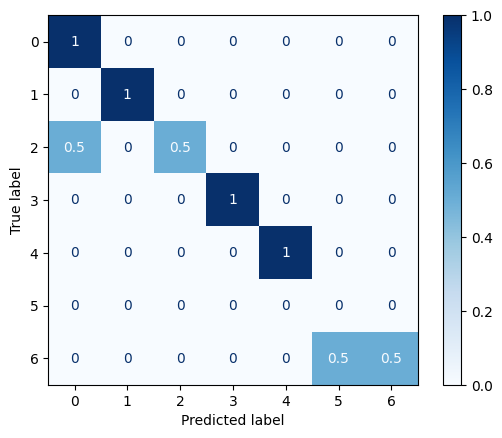

In [46]:
plot_confusion_matrix_from_train_outputs(train_outputs, tokenized_validation_dataset['label'])

In [48]:
id2label

{0: 'assisi',
 1: 'finocchio',
 2: 'naturalmente',
 3: 'seimostro',
 4: 'song',
 5: 'sonomatto',
 6: 'sporcizia'}